In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(rc={'figure.figsize':(13.7,10.27)})
sns.set_style("whitegrid")
sns.set_color_codes()

In [2]:
from dask.distributed import Client
import dask.bag as db
import dask.dataframe as dd
import dask

from ast import literal_eval
from collections import MutableMapping
import dask.array as da
# import h5py
import os

In [4]:
client = Client(n_workers=8)

/home/ej/github/cmpe256-team4/cmpe256-team4/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41835 instead
  http_address["port"], self.http_server.port


In [5]:
client

Client Scheduler: tcp://127.0.0.1:37043 Dashboard: http://127.0.0.1:41835/status,Cluster Workers: 8 Cores: 16 Memory: 33.65 GB


In [ ]:
from ast import literal_eval
from collections import MutableMapping

b = db.read_text("data/reviews.clean.json", blocksize="64MiB")

In [6]:
def drop_cols(obj):
    obj.pop('reviewerName')
    obj.pop('reviewText')
    obj.pop('unixReviewTime')
    obj.pop('reviewTime')
    
    return obj

In [7]:
def extract_restaurant_and_pub(obj):
    if obj["categories"]:
        for cat in obj["categories"]:
            if "Restaurant" in cat or "Pub" in cat or "Bar" in cat:
                return 1
    return 0

In [8]:
df = b.map(literal_eval).map(drop_cols).to_dataframe().repartition(npartitions=240)

In [ ]:
df.dropna(subset=['price', 'address']).drop(columns=['name','hours','gps','phone','closed'])

In [1]:
# # Extract reviews only whose categories are related to Restaurants, Pubs, or Bars
# df["target"] = df.loc[:, ["categories"]].apply(extract_restaurant_and_pub, axis=1)
# df[(df["rating"].notnull()) & (df["target"]==1)].drop(["target"], axis=1).to_csv("only_restaurants_review.csv", index=False)

In [9]:
only_restaurants = dd.read_csv('only_restaurants_review.csv/*.part', blocksize='64MiB')

In [11]:
only_restaurants["rating"].compute()

0       4.0
1       5.0
2       5.0
3       4.0
4       5.0
       ... 
2428    2.0
2429    2.0
2430    4.0
2431    1.0
2432    1.0
Name: rating, Length: 4170168, dtype: float64

In [11]:
partial_df["rating"].value_counts()

5.0    5722956
4.0    2689692
3.0    1510797
2.0     921153
1.0     609203
0.0         44
Name: rating, dtype: int64

<AxesSubplot:xlabel='rating', ylabel='Count'>

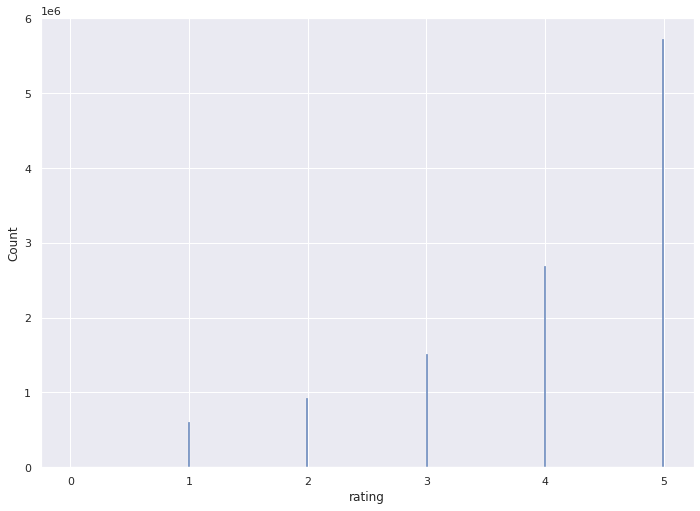

In [41]:
sns.histplot(partial_df, x="rating")

In [38]:
# ReviewTime to Season, recent(<1, 2> )
# unixReviewTime to day-open, 24/7 etc
# Display reviews histogram by timezone (morning ,lunch, afternoon, dinner etc)

In [44]:
category = {}
def count_cat(obj):
    if obj["categories"]:
        for cat in obj["categories"]:
            category[cat] = category.get(cat, 0) + 1
    return obj

In [46]:
df.apply(count_cat, axis=1).compute()

/home/ej/github/cmpe256-team4/cmpe256-team4/lib/python3.6/site-packages/dask/dataframe/core.py:4338: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta={'rating': 'float64', 'categories': 'object', 'gPlusPlaceId': 'object', 'gPlusUserId': 'object'})

  warnings.warn(meta_warning(meta))


,rating,categories,gPlusPlaceId,gPlusUserId
0,3.0,[Giải Trí - Café],108103314380004200232,100000010817154263736
1,5.0,[Turkish Cuisine],102194128241608748649,100000013500285534661
2,5.0,"[Fishing, Pond Fish Supplier, Seafood Market]",101409858828175402384,100000021336848867366
3,5.0,[Museum],101477177500158511502,100000021336848867366
4,4.0,[Police],106994170641063333085,100000021336848867366
...,...,...,...,...
90517,4.0,[School],110302363754248466279,118446743512419806874
90518,4.0,[Lodging],110811510477289064667,118446743512419806874
90519,5.0,[Medical Center],114800547590362276647,118446743512419806874
90520,5.0,None,106919006909432779494,118446743745545869532


In [48]:
# Display most popular food genre by count
# e.g. American, Mexican, SeaFood etc
count = pd.Series(category).sort_values(ascending=False)
count[count >= 1000].index

Index(['Restaurant', 'Hotel', 'European Restaurant', 'Asian Restaurant',
       'American Restaurant', 'Italian Restaurant', 'Bar', 'Pizza Restaurant',
       'Fast Food Restaurant', 'Cafe',
       ...
       'Car Rental', 'Accountant', 'Real Estate Agents', 'Bus Station',
       'Box Lunch Supplier', 'Landmark', 'Cottage', 'Siding Contractor',
       'Continental Restaurant', 'Trial Attorney'],
      dtype='object', length=735)

In [49]:
count[(1000>count) & (count>500)].index

Index(['Watch Repair Service', 'Manufacturing, Mining...', 'Ethnic Restaurant',
       'Banking and Finance', 'Appliance Parts Supplier',
       'Pain Management Physician', 'Glass Repair Service',
       'Children's Museum', 'Recycling Center', 'Computer Software Store',
       ...
       'Burglar Alarm Store', 'Tourism', 'Furniture Maker',
       'Lawn Sprinkler System...', 'Airport Terminal',
       'North African Restaurant', 'Tour Operator', 'Police Station',
       'Perfume Store', 'Alcoholism Treatment Program'],
      dtype='object', length=330)

In [50]:
count[count >= 500].index

Index(['Restaurant', 'Hotel', 'European Restaurant', 'Asian Restaurant',
       'American Restaurant', 'Italian Restaurant', 'Bar', 'Pizza Restaurant',
       'Fast Food Restaurant', 'Cafe',
       ...
       'Tourism', 'Furniture Maker', 'Lawn Sprinkler System...',
       'Airport Terminal', 'North African Restaurant', 'Tour Operator',
       'Police Station', 'Perfume Store', 'Alcoholism Treatment Program',
       'Digital Printer'],
      dtype='object', length=1066)

In [60]:
category_series = pd.Series(category)
restaurants = category_series[category_series.index.str.contains("Restaurant") | category_series.index.str.contains("Bar") | category_series.index.str.contains("Pub") ].sort_values(ascending=False)
restaurants.drop(["Restaurant"], inplace=True)
populars = restaurants[restaurants > 50000]
populars

European Restaurant          185781
Asian Restaurant             167235
American Restaurant          152835
Italian Restaurant           149581
Bar                          128797
Pizza Restaurant             118426
Fast Food Restaurant         108483
Chinese Restaurant            78273
Mexican Restaurant            76122
Latin American Restaurant     65214
Seafood Restaurant            57554
Hamburger Restaurant          55097
Japanese Restaurant           54346
Pub                           50901
dtype: int64

In [61]:
pd_df = pd.DataFrame(data={
    "genre": populars.index.map(lambda x: x.replace("Restaurant", "")),
    "count": populars.values
})
pd_df

,genre,count
0,European,185781
1,Asian,167235
2,American,152835
3,Italian,149581
4,Bar,128797
5,Pizza,118426
6,Fast Food,108483
7,Chinese,78273
8,Mexican,76122
9,Latin American,65214


<AxesSubplot:xlabel='count', ylabel='genre'>

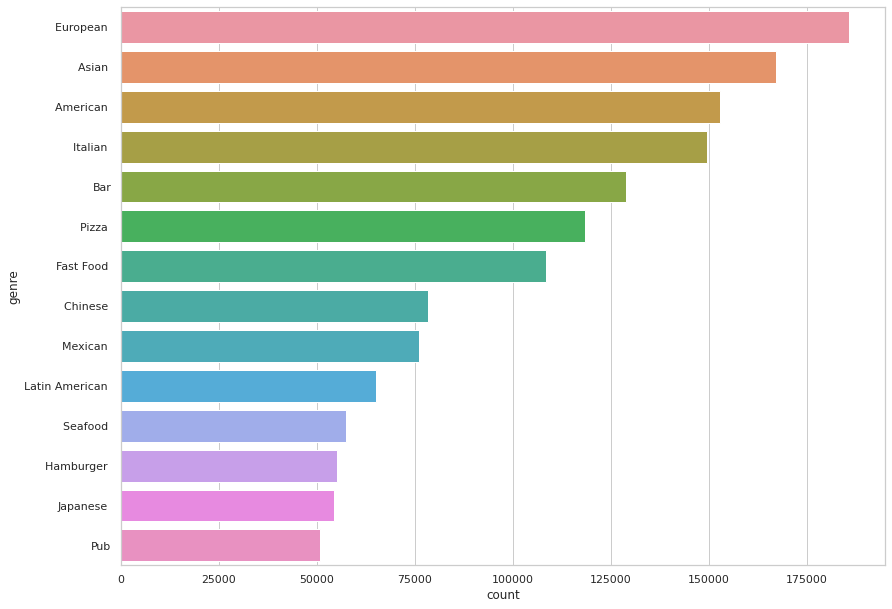

In [62]:
sns.barplot(y="genre", x="count", data=pd_df, capsize=.2)

In [34]:
# Idea 1
# Row = User
# Col = Place Category (not each restaurant)
# If certain category is recommended, then choose one of restaurants with the category?
# (or make another recommender system within the category...?)

In [35]:
# Idea2
# Col = Each Restaurant (too many?)

In [ ]:
# Idea3
# Col = Restaurant&Food&Grocery, Movie&Cinema&Opera, Soccer&BasketBall&gym&Swimming, Shopping, Cafe

In [ ]:
# Idea4
# Feature
# 1. Quality Place = rating >= 4 or 5 (by join and aggregate)
# 2. Popular Place = # of reviews > N
# 3. Quiet Place = else
# 4. Only Open at Day? or All Day?
# 5. Near the beach? ( by GPS )

# Exclude Places whose ratings are under 2?

# How to reflect features 
# other than user and places into recommender system?
# => Content Based (e.g. Day? night? and food "Genre"s)